In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import re
import warnings

warnings.filterwarnings('ignore')

In [6]:
# read the data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df = pd.read_csv('C:/Research Folder/SimpleML_Project/train.csv', encoding='latin1')
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [8]:
# removing unnecessary characters
def remove_unnecessary_characters(text):
    text = re.sub(r'<.*?>', '', str(text))
    text = re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
    text = re.sub(r'\s+', ' ', str(text)).strip()
    return text

df['clean_text'] = df['text'].apply(remove_unnecessary_characters)

In [ ]:
# tokenization
def tokenize_text(text):
    try:
        text = str(text)
        tokens = word_tokenize(text)
        return tokens
    except Exception as e:
        print(f"Error tokenizing text: {e}")
        return []
    
df['tokens'] = df['text'].apply(tokenize_text)

In [11]:
# data normalization
def normalization_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
    else:
        text=str(text)
    return text

df['normalized_text'] = df['text'].apply(normalization_text)

In [13]:
# Removing stopwords
def remove_stopwords(text):
    if isinstance(text, str):
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in stopwords.words(['english'])]
        filtered_text = ' '.join(filtered_words)
    else:
        filtered_text = ''
    return filtered_text

df['text_without_stopwords'] = df['text'].apply(remove_stopwords)

In [17]:
# removing missing values
df.dropna(inplace=True)

<Axes: xlabel='sentiment'>

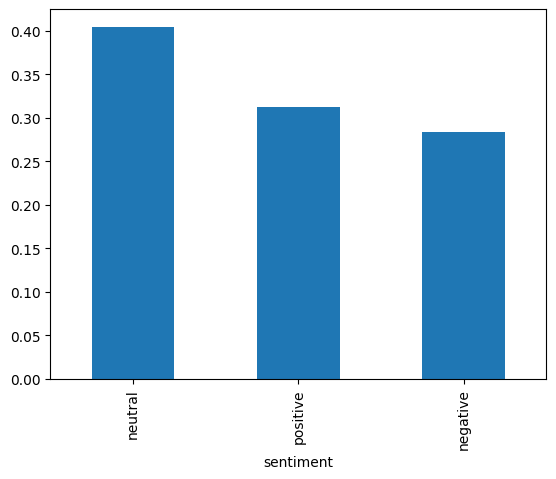

In [18]:
# Sentiment value counts
df['sentiment'].value_counts(normalize=True).plot(kind='bar')

In [19]:
# convert to strings
final_corpus = df['text'].astype(str).tolist()
data_eda = pd.DataFrame()
data_eda['text'] = final_corpus
data_eda['sentiment'] = df['sentiment'].values
data_eda.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [21]:
# removing irrelevant columns
df = df.drop(columns=[
    'textID',
    'Time of Tweet',
    'Age of User',
    'Country',
    'Population -2020',
    'Land Area (Km²)',
    'Density (P/Km²)'
])

In [22]:
import string
def wp(text):
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
df['selected_text'] = df["selected_text"].apply(wp)

In [33]:
# Evaluation of Dataset
X = df['selected_text']
y = df['sentiment']

In [34]:
# splitting the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# creating TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorization = TfidfVectorizer()
XV_train = vectorization.fit_transform(X_train)
XV_test = vectorization.transform(X_test)

In [45]:
score_baseline = df['sentiment'].value_counts(normalize=True).max()
score_baseline

0.40454876273653567

In [46]:
# Applying Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(n_jobs=-1)
lr.fit(XV_train, y_train)

LogisticRegression(n_jobs=-1)

In [70]:
pred_lr = lr.predict(XV_test)
pred_lr

array(['positive', 'neutral', 'neutral', ..., 'neutral', 'neutral',
       'neutral'], dtype=object)

In [52]:
# checking the score
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
score_lr = accuracy_score(y_test, pred_lr)
score_lr

0.8286026200873362

In [53]:
# printing the classification report
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

    negative       0.81      0.79      0.80      1572
     neutral       0.79      0.88      0.83      2236
    positive       0.91      0.80      0.85      1688

    accuracy                           0.83      5496
   macro avg       0.84      0.82      0.83      5496
weighted avg       0.83      0.83      0.83      5496



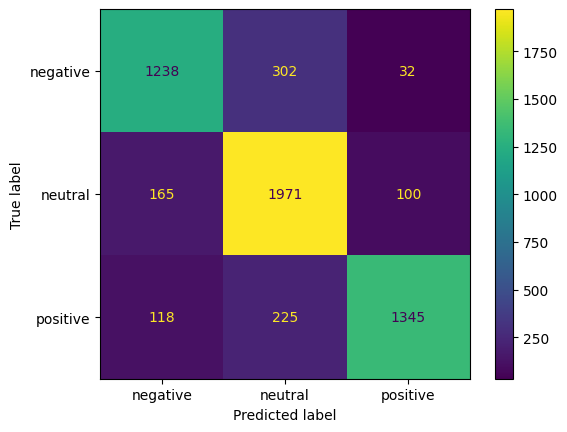

In [54]:
ConfusionMatrixDisplay.from_predictions(y_test, pred_lr)

In [65]:
# function to display sentiment analysis over a text
def output_label(n):
    if n == "negative":
        return "The Text Sentiment is Negative"
    elif n=="neutral":
        return "The Text Sentiment is Neutral"
    elif n=="positive":
        return "The Text Sentiment is Positive"
    
def manual_testing(sample_text):
    testing_text = {"text":[sample_text]}
    new_df = pd.DataFrame(testing_text)
    new_df['text'] = new_df['text'].apply(wp)
    new_x_test = new_df['text']
    new_xv_test = vectorization.transform(new_x_test)
    pred_lr = lr.predict(new_xv_test)

    #print(pred_lr[0])

    return print(output_label(pred_lr[0]))

In [68]:
# testing
manual_testing("I hate her of love")

The Text Sentiment is Positive
